<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Trans-Neptunian Objects (TNOs)</b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run: July 24 2023 <br>
LSST Science Pipelines version: w_2023_21  <br>
Container Size: medium <br>
Targeted learning level: intermediate<br>

**Description:** Explore the trans-Neptunian object populations in DP0.3. 

**Skills:** Use of the DP0.3 catalogs to study TNO populations.

**LSST Data Products:**  DP0.3 catalogs `SSObject` and `MPCORB`.

**Packages:** `lsst.rsp`

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham, the Rubin Community Science Team for DP0.3, and Pedro Bernardinelli (University of Washington). 
This tutorial is based on a Jupyter Notebook by Pedro Bernardinelli. 
This notebook has made used of suggestions in the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist).

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a> and <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. 
Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

## 1. Introduction

### 1.1 Trans-Neptunian objects (TNOs)

A trans-Neptunian object (TNO) is categorized as a minor planet within the Solar System. It orbits the Sun at an average distance greater than that of Neptune, which possesses a semi-major axis measuring approximately 30.1 astronomical units (AU). The population of minor bodies orbiting our Sun beyond Neptune are largely intact relics from the era of planetary formation. 

In the current model explaining the formation of the outer Solar System, the small building blocks of planets, called planetesimals, that eventually became TNOs can be categorized into two groups:

- Outwardly Migrated "Hot" TNOs: Some planetesimals formed within the inner region of the protoplanetary disk, located at a distance less than 30 Astronomical Units (AU) from the Sun. These planetesimals were later pushed outward by interactions with a migrating Neptune. As a result, they acquired dynamically "hot" orbits.

- In-Situ "Cold" TNOs: Other planetesimals formed directly in the trans-Neptunian region, where they remain with dynamically "cold" orbits.

#### 1.1.1 Dynamical classes

In Section 4, clustering within plots of eccentricity or inclination versus semi-major axis
will be used to identify the following TNO dynamical classes.

**Classical**: There is a population of TNOs called the *Classical* TNOs situated between Neptune's 3:2 and 2:1 mean motion resonances, at distances ranging from 39 to 47 AU, and characterized by low eccentricity (e < ~ 0.3). This group is a mix of two types of objects: some are native and remained dynamically "cold," while others were originally "hot" objects that migrated into this region.

**Scattering**: Another population is known as the *Scattering* TNOs, which can have orbits extending to large distances, but their orbits are currently experiencing significant variations due to perturbations caused by Neptune when their closest distance to the Sun (perihelia `q`) is less than approximately 40 AU. These Scattering TNOs are believed to be remnants of a population that was scattered during the early formation of the Solar System and have managed to survive for a long time.

**Resonant**: TNOs are currently found in stable mean motion resonances with Neptune, meaning they have a specific orbital relationship with the planet. It is presumed that they were transported outward while maintaining their resonant positions as Neptune migrated during the early history of the Solar System.

**Detached**: In contrast, the *Detached* TNOs have higher perihelia and are dynamically independent from Neptune, as they currently maintain stable orbits that are not significantly influenced by Neptune's gravitational effects. These Detached TNOs might have originated as Scattering TNOs whose perihelia were raised through past resonance interactions with Neptune or through interactions with a distant, massive planet in the outer Solar System (though this hypothetical planet has not been observed yet). The "Detached" familie of TNOs is among the most enigmatic one, and the questions about where they formed and how they got to their orbits are still open.  

**Extreme**: There is another class of TNOs referred to as *extreme*. These extreme TNOs are characterized by their exceptional distances from the Sun, with semi-major axes (a) exceeding 150 AU (note that definitions may vary slightly) and `q` > 40 AU.  The formation mechanism responsible for producing these distant extreme TNOs remains unclear. One prominent hypothesis involves the presence of a massive object often referred to as "Planet X" or "Planet 9" situated at approximately 400 AU from the Sun. The gravitational influence of this hypothetical Neptune-mass planet could have played a significant role in sculpting the distribution of these extreme TNOs, leading to the anisotropies observed in their orbital characteristics.

#### 1.1.2 References

The above information was compiled from the following articles.

*A Search of the Full Six Years of the Dark Energy Survey for Outer Solar System Objects*, [Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract)

*Transneptunian Space*, [Gladmann and Volk (2021), AR&AA](https://ui.adsabs.harvard.edu/abs/2021ARA%26A..59..203G/abstract)

*The Outer Solar System Origins Survey (OSSOS). VII. 800+ Trans-Neptunian Objects — The Complete Data Release*, [Banister et al (2018), ApJS](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...18B/abstract)


### 1.2 Import packages

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, numerical analysis, and astronomical data analysis.

The `cycler` package enables automatic cycling through default color options when plotting.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for access to the DP0 catalogs.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps
from matplotlib.patches import Polygon
import numpy as np
import astropy.units as u
from cycler import cycler
from lsst.rsp import get_tap_service

### 1.3 Define functions and parameters

The following functions and parameters are defined once, and used throughout this notebook.

**_Parameter_**: `a_Neptune`

Neptune's mean semimajor axis ($a_{Neptune}$).

In [3]:
a_Neptune = 30.11

**_Function_**: `estimateDiameter`

Estimate the diameter ($d$), in kilometers, of a Solar System body
given its absolute H magnitude ($H$) and albedo ($A$).
The term "albedo" refers to the fraction of light reflected, from 0 to 1.

$d = 10^{(3.1236\ -\ 0.5 \log(A)\ -\ 0.2H)}$

In [4]:
def estimateDiameter(H, albedo=0.15):
    """
    Return Solar System object size in kilometers.

    Parameters
    ----------
    H : `float`
        Solar System absolute magnitude
    albedo: `float`
        Solar system object albedo

    Returns
    -------
    d : `float`
        Estimated diameter of the object, in kilometers.
    """

    d = np.power(10., 3.1236 - 0.5*np.log10(albedo) - 0.2*H)
    return d

#### 1.3.1 Functions and parameters for plotting

The following two functions set the aesthetics when plotting eccentricy (or inclination) versus semi-major axis.
These functions were taken from [Stack Overflow](https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib).

They are long, and so they have been hidden.
Click the three dots to reveal the code; click the bar (blue or orange) to the left of the cell to hide the code.

**_Function_**: `gradientFill`

Plot a line with a linear gradient filled beneath it.

In [5]:
def gradientFill(x, y, alpha=1, fill_color=None, ax=None, invert=False, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    alpha : float
        Transparency for plotted element, 0 for transparent, 1 for opaque.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    invert : boolean
        Whether to invert the gradient.

    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, alpha=0, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
#    alpha = line.get_alpha()
#    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    z[:, :, -1] = np.linspace(0, alpha, 100)[:, None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='upper', zorder=zorder)

    xy = np.column_stack([x, y])

    if invert == 0:
        xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    else:
        xy = np.vstack([[xmax, ymax], xy, [xmin, ymax], [xmin, ymin]])

    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

#    ax.autoscale(True)
    return line, im

**_Function_**: `plotResonances`

Calculate mean motion resonances with Neptune and plot them as vertical dashed lines.

In [6]:
def plotResonances(ax, k, k_N, y_loc=None, a_shift=0.75, alpha=0.2):
    """
    Plot Neptune resonances.

    Parameters
    ----------
    ax : `matplotlib...`
       Figure axes.

    """
    a_res = a_Neptune * np.cbrt(float(k)**2/float(k_N)**2)
    ax.axvline(a_res, linewidth=2, alpha=alpha, linestyle='--')
    if y_loc is not None:
        ax.annotate(r'${}:{}$'.format(k, k_N),
                    (a_res + a_shift, y_loc), rotation=90, fontsize=16)
    return ax

**_Parameters_**: Set plotting parameters to make visually accessible plots.

In [7]:
plt.style.use('tableau-colorblind10')

params = {'lines.linewidth': 2,
          'lines.linestyle': '-',
          'lines.color': 'black',
          'patch.linewidth': 2,
          'font.family': 'serif',
          'font.weight': 'medium',
          'font.size': 14.0,
          'text.color': 'black',
          'axes.edgecolor': 'black',
          'axes.linewidth': 2.0,
          'axes.grid': False,
          'axes.titlesize': 'xx-large',
          'axes.labelsize': 'xx-large',
          'axes.labelweight': 'medium',
          'axes.labelcolor': 'black',
          'axes.formatter.limits': (-4, 4),
          'xtick.major.size': 10,
          'xtick.minor.size': 5,
          'xtick.major.pad': 8,
          'xtick.minor.pad': 8,
          'xtick.labelsize': 'xx-large',
          'xtick.minor.width': 2.0,
          'xtick.major.width': 2.0,
          'xtick.minor.visible': True,
          'ytick.major.size': 10,
          'ytick.minor.size': 5,
          'ytick.major.pad': 8,
          'ytick.minor.pad': 8,
          'ytick.labelsize': 'xx-large',
          'ytick.minor.width': 1.0,
          'ytick.major.width': 1.0,
          'ytick.minor.visible': True,
          'axes.prop_cycle': cycler('color',
                                    ['xkcd:cerulean blue',
                                     'xkcd:scarlet',
                                     'xkcd:grass green',
                                     'xkcd:light orange',
                                     'xkcd:lighter purple',
                                     'xkcd:bright aqua',
                                     'xkcd:dirt brown',
                                     'xkcd:gunmetal',
                                     'xkcd:dark hot pink',
                                     'xkcd:very dark brown']),
          'legend.numpoints': 1,
          'legend.fontsize': 'x-large',
          'legend.shadow': False,
          'legend.frameon': True,
          'legend.fancybox': True,
          'figure.titlesize': 'xx-large',
          'figure.figsize': (8, 6),
          'figure.facecolor': 'white'}
plt.rcParams.update(params)

## 2. Query the `MPCORB` table for all TNOs

Start the TAP service for DP0.3 Solar System data, ``ssotap``.

In [8]:
service = get_tap_service("ssotap")

The contents of the `MPCORB` table were explored in the introductory DP0.3 notebook.

**Option:** Uncomment the following cell to view the column descriptions for the `MPCORB` catalog as a `pandas` table.

In [9]:
# results = service.search("SELECT column_name, datatype, description, "
#                          "unit from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp03_catalogs.MPCORB'")
# results.to_table().to_pandas()

Create a query that will retrive the Solar System object ID (`ssObjectid`);
the orbital elements eccentricity (`e`), 
inclination (`incl`; degrees),
perihelion distance (`q`; AU),
longitude of the ascending node (`node`; degrees), 
and argument of the perihelion (`peri`; degrees);
and the absolute H magnitude (`mpcH`).

TNOs, by definition, have a semi-major axis greater than the mean semi-amjor axis of Neptune, 30.11 AU (`a_Neptune`).
The semi-major axis (`a`) is not included in the `MPCORB` table because it
can be derived from the eccentricity and perihelion distance as $a = \frac{q}{1-e}$.
Include a constraint in the query to only return objects with semi-major axes greater than this limit:
`WHERE (mpc.q / (1 - mpc.e) > {a_Neptune})`.

In order to robustly measure the absolute H magnitudes and the orbital elements for a TNO,
multiple observations over time are required. 
The minimum number of observations needed for a given analysis will depend on the science goals
and the precision required, and is ultimately left to the discretion
of the scientist.
Here, as an example, use a limit of 10 observations (`min_num_obs`).
The number of observations are stored in the `numObs` column of the `SSObject` table,
so including this constraint requires a `JOIN` with this table.

Finally, include the constraint that the eccentricity must be less than 1 to reject any 
TNOs with catastrophic failures in eccentricity calculations. 

The following query returns 48574 TNOs, which is about an order of magnitude greater than 
the current number of confirmed TNOs, and is consistent wth expectations and forecast for LSST Y10.

In [10]:
min_num_obs = 10
tnos = service.search("SELECT mpc.ssObjectId, mpc.e, mpc.incl, mpc.q, "
                      "mpc.node, mpc.peri, mpc.mpcH "
                      "FROM dp03_catalogs.MPCORB as mpc "
                      "JOIN dp03_catalogs.SSObject as sso "
                      "ON mpc.ssObjectId = sso.ssObjectId "
                      f"WHERE (mpc.q / (1 - mpc.e) > {a_Neptune}) "
                      f"AND sso.numObs > {min_num_obs} "
                      "AND mpc.e < 1 ").to_table()
print(len(tnos))

48574


### 2.1 Calculate semi-major axis

Calculate the semi-major axis, `a`, for all TNOs and add it to the table.

In [11]:
tnos['a'] = tnos['q'] / (1.0 - tnos['e'])

## 3. Estimate diameters for TNOs

**Absolute H magnitudes**

For Solar System objects, absolute `H` magnitudes are defined to be for an object 1 AU from the Sun and 1 AU 
from the observer, and at a phase angle (the angle Sun-object-Earth) of 0 degrees.
Absolute `H` magnitudes are derived by correcting for distance, fitting a function to the relationship between
absolute magnitude and phase (the slope of which is referred to as the `G` magnitude; `mpcG` in the `MPCORB` table), 
and evaluating the function at a phase of 0 deg.
The `H` and `G` magnitudes in different filters can reveal the the surface properties and composition of asteroids.

The `H` magnitude is specifically used for objects that primarily reflect sunlight, such as asteroids, since their brightness depends on their distance from the Sun and the observer, 
and their "albedo" (the fraction of light reflected, from 0 to 1).

**Albedo and diameter**

Knowing the albedo of an object is a challenge beyond the scope of this notebook.
In order to demonstrate how to estimate diameters, an albedo value of 0.2 is assumed.

> **Warning**: Calculating an accurate size for a Solar System object typically requires 
additional measurements, such as radar observations, or studying its shadow during occultations.

Use the `estimateDiameter` function to estimate the diameters, in kilometers, for all of the TNOs.

In [14]:
albedo = 0.2
sizes_tnos = estimateDiameter(tnos['mpcH'], albedo=albedo)

Plot the distribution of estimated diameters.

Text(0.5, 1.0, 'TNO sizes for albedo = 0.2')

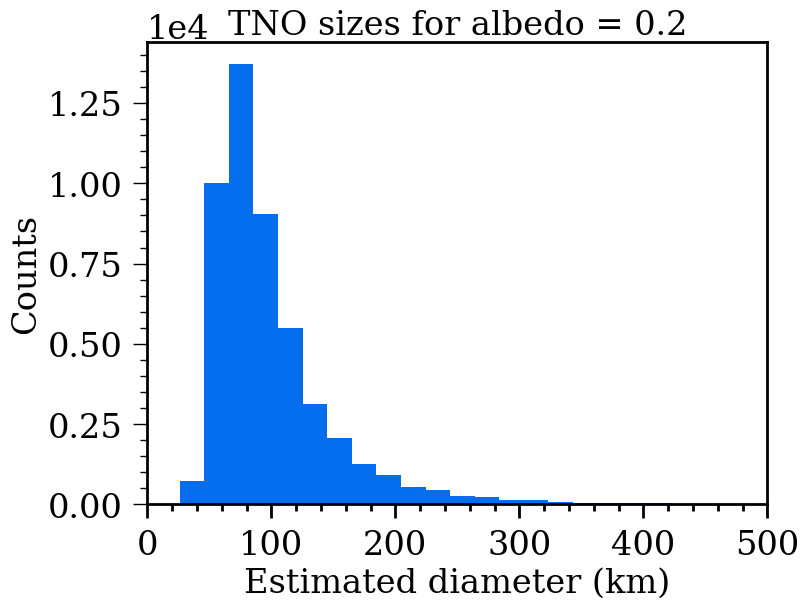

In [25]:
fig, axs = plt.subplots(1, 1)
axs.hist(sizes_tnos, bins=100)
plt.xlim([0, 500])
plt.xlabel('Estimated diameter (km)')
plt.ylabel('Counts')
plt.title(f"TNO sizes for albedo = {albedo}")

## 4. Identify dynamical classes of TNOs

The dynamical classes of TNOs are defined by their orbital parameters, 
which show clustering in the parameter space of eccentricity or inclination
versus semi-major axis.

To explore first the relationships between these orbital parameters,
plot all of the TNOs together by executing the cell below.

After, uncomment the two lines to `set_ylim` and `set_xlim`, and re-execute the following cell,
to further zoom in and view the clustering in parameter space.

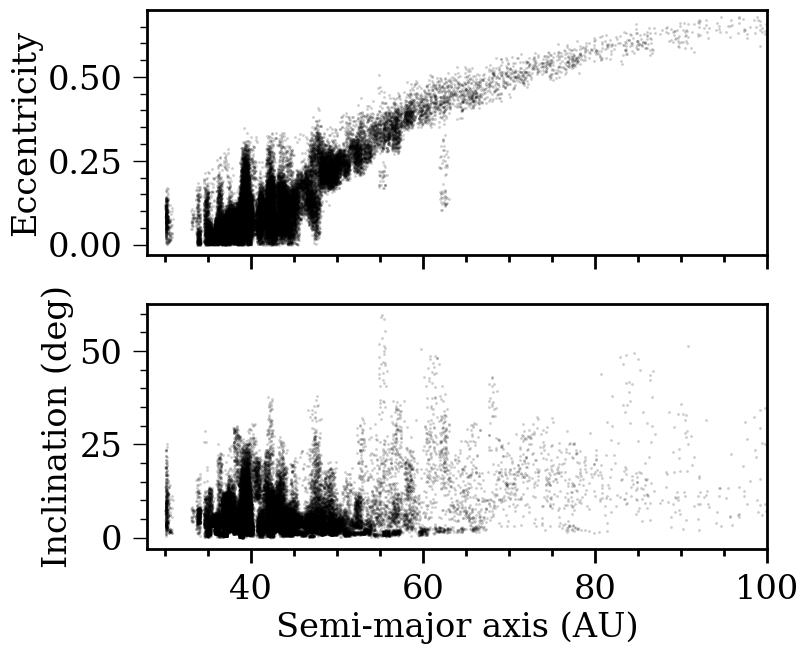

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))

ax1.plot(tnos['a'], tnos['e'], 'o', ms=2, alpha=0.2, mew=0, color='black')
ax1.set_ylabel('Eccentricity')

ax2.plot(tnos['a'], tnos['incl'], 'o', ms=2, alpha=0.2, mew=0, color='black')
ax2.set_ylabel('Inclination (deg)')
ax2.set_xlabel('Semi-major axis (AU)')

# ax1.set_ylim([-0.03, 0.7])
# ax2.set_xlim([28, 100])

plt.show()

**Why is there clustering in semi-major axis?**

The clustering in semi-major axis is due to *resonances*.
Since Neptune is so much more massive than a TNO, it influences the regions
of orbital element parameter space that are stable, 
and orbits that are "in resonance with Neptune" are stable orbits for TNOs.

TNOs with orbital periods that are in, for example, a 1:1 resonance with Neptune
have the same period, $P$, and thus same semi-major axis, $a$, because $P^2 \propto a^3$.
TNOs in a 2:1 resonance with Neptune have double the period, and thus $4^{1/3} = 1.6\times$ the 
semi-major axis, or $\sim47$ AU.

### 4.1 Use known dynamical class boundaries to identify members

Below, define the boundaries to clasify the TNOs in the following dynamical classes: 
scattering, detached, classical, and extreme. 

> **Warning**: In the liternature, class definitions may vary!
This notebook is using the same definitions as [Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract),
which found nearly 800 TNOs in the Dark Energy Survey Year 6 data,
in order to recreate their Figure 8 below.

In [40]:
max_a_classical = 47
min_a_classical = 40
max_e_classical = 0.24
mask_classical = ((tnos['a'] >= min_a_classical) & (tnos['a'] <= max_a_classical)
                  & (tnos['e'] <= max_e_classical))

min_q_detached = 38
mask_detached = ((tnos['a'] > max_a_classical) & (tnos['e'] > max_e_classical)
                 & (tnos['q'] >= min_q_detached))

mask_scattering = ~mask_classical & (tnos['q'] < min_q_detached)

min_a_extreme = 150
min_q_extreme = 30
mask_extreme = (tnos['a'] > min_a_extreme) & (tnos['q'] > min_q_extreme)

Create a new array called `classes` that contains strings labeling the dynamical class for each object.
Initialize this array with the string "Other" to cover unclassified TNOs.

In [63]:
other_string = "Other     "
classes = np.repeat(other_string, len(tnos))

In [64]:
classes[mask_classical] = 'Classical'
classes[mask_detached] = 'Detached'
classes[mask_scattering] = 'Scattering'
classes[mask_extreme] = 'Extreme'

Add the contents of the `classes` array as a new column to the TNO table.

In [65]:
tnos['class'] = classes

Confirm that the only unique values of the `class` column are the five classes defined above.

Print the number of TNOs identified as each class.

In [67]:
class_strings, class_counts = np.unique(tnos['class'], return_counts = True)
for s, string in enumerate(class_strings):
    print('%-12s %6i' % (class_strings[s], class_counts[s]))

Classical     17615
Detached       1086
Extreme          20
Other          4240
Scattering    25613


### 4.2 Visualize the dynamical classes

Define five colors to use, one for each class.

In [47]:
colors = ['xkcd:scarlet', 'xkcd:light purple', 'xkcd:light orange',
          'xkcd:light pink', 'xkcd:cerulean blue']
class_to_color = {}
for i, c in enumerate(class_strings):
    class_to_color[c] = colors[i]
class_to_color

{'     Other': 'xkcd:scarlet',
 'Classical': 'xkcd:light purple',
 'Detached': 'xkcd:light orange',
 'Extreme': 'xkcd:light pink',
 'Scattering': 'xkcd:cerulean blue'}

Recreate Figure 8 from 
[Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract),
but impose a limit on semi-major axis of 100 AU which excludes the extreme dynamical class.

Class Type | Number 
Classical 17615
Scattering 25613
Detached 1086
Extreme 20
     Other 4240


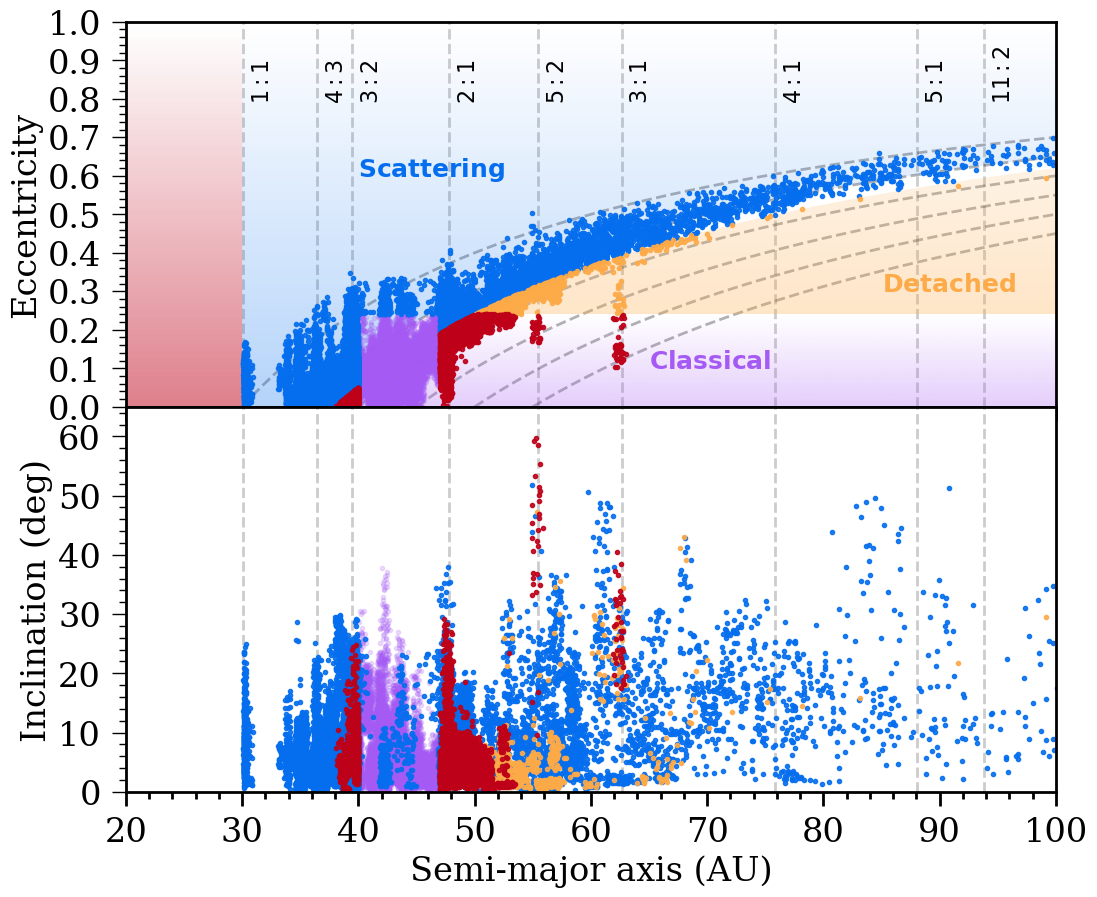

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.rcParams["image.composite_image"] = False
e = np.linspace(0, 0.99999, 10000)

for i in [30, 35, 40, 45, 50,55]:
    ax1.plot(i/(1-e), e, 'k--', alpha=0.3)

for i,j in zip([1, 2, 3, 3, 4, 4, 5, 5, 11],
               [1, 1, 1, 2, 1, 3, 2, 1, 2]):
    ax1 = plotResonances(ax1, i, j, 0.8)
    ax2 = plotResonances(ax2, i, j, )

gradientFill(30/(1-e), e, ax=ax1, alpha=0.3, invert=True)

gradientFill(min_q_detached/(1-e)[e > max_e_classical], e[e>max_e_classical],
              ax = ax1, alpha=0.3, color='xkcd:light orange')

scat = np.append(30/(1-e), 35/(1-e)[::-1])
scat_e = np.append(e, e[::-1])

gradientFill(scat, scat_e, ax = ax1, alpha=0.3, color='xkcd:cerulean blue')
cl = np.append(35/(1 - e)[e < max_e_classical], 100)
e_cl = np.append(e[e < max_e_classical], 0.24)
gradientFill(cl, e_cl, ax = ax1, alpha=0.3, color='xkcd:lighter purple')

gradientFill(np.array([20, 30, 30]), np.array([0,0,1]), invert=True, 
                  ax=ax1, alpha=0.5, color='xkcd:scarlet')

print ("Class Type | Number ")
for c, j in zip(['Classical', 'Scattering', 'Detached', 'Extreme', '     Other'],
                ['xkcd:lighter purple', 'xkcd:cerulean blue', 'xkcd:light orange', 
                 'xkcd:leaf green', 'xkcd:scarlet']):
    b = tnos[tnos['class'] == c]
    print (c, len(b))
    alp = 0.9
    if c == 'Classical':
        alp = 0.2
    ax1.plot(b['a'], b['e'], '.', alpha=alp, color=j)
    ax2.plot(b['a'], b['incl'], '.', alpha=alp, color=j)

ax1.text(40, 0.6, r'$\bf{Scattering}$', rotation=0, color='xkcd:cerulean blue', fontsize=18,)
ax1.text(85, 0.3, r'$\bf{Detached}$', rotation=0, color='xkcd:light orange', fontsize=18,)
ax1.text(65, 0.1, r'$\bf{Classical}$', rotation=0, color='xkcd:lighter purple', fontsize=18,)

ax1.set_xticks(np.arange(20, 110, 10))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 70, 10))

ax1.set_ylim(0, 1)
ax2.set_xlabel('Semi-major axis (AU)')
ax1.set_ylabel('Eccentricity')
ax2.set_ylabel('Inclination (deg)')
ax2.set_ylim(0, 65)
ax1.set_xlim(20, 100)
ax2.set_xlim(20, 100)
fig.set_size_inches(12, 10)
plt.show()

Below, extend the plot in semi-major axies to include "extreme" TNOs and objects from the Oort Cloud (comets).
As none of the latter are included in the DP0.3 simulation, there are no points in the far-right part of the plot.

Classical 17615
Scattering 25613
Detached 1086
Extreme 20
     Other 4240


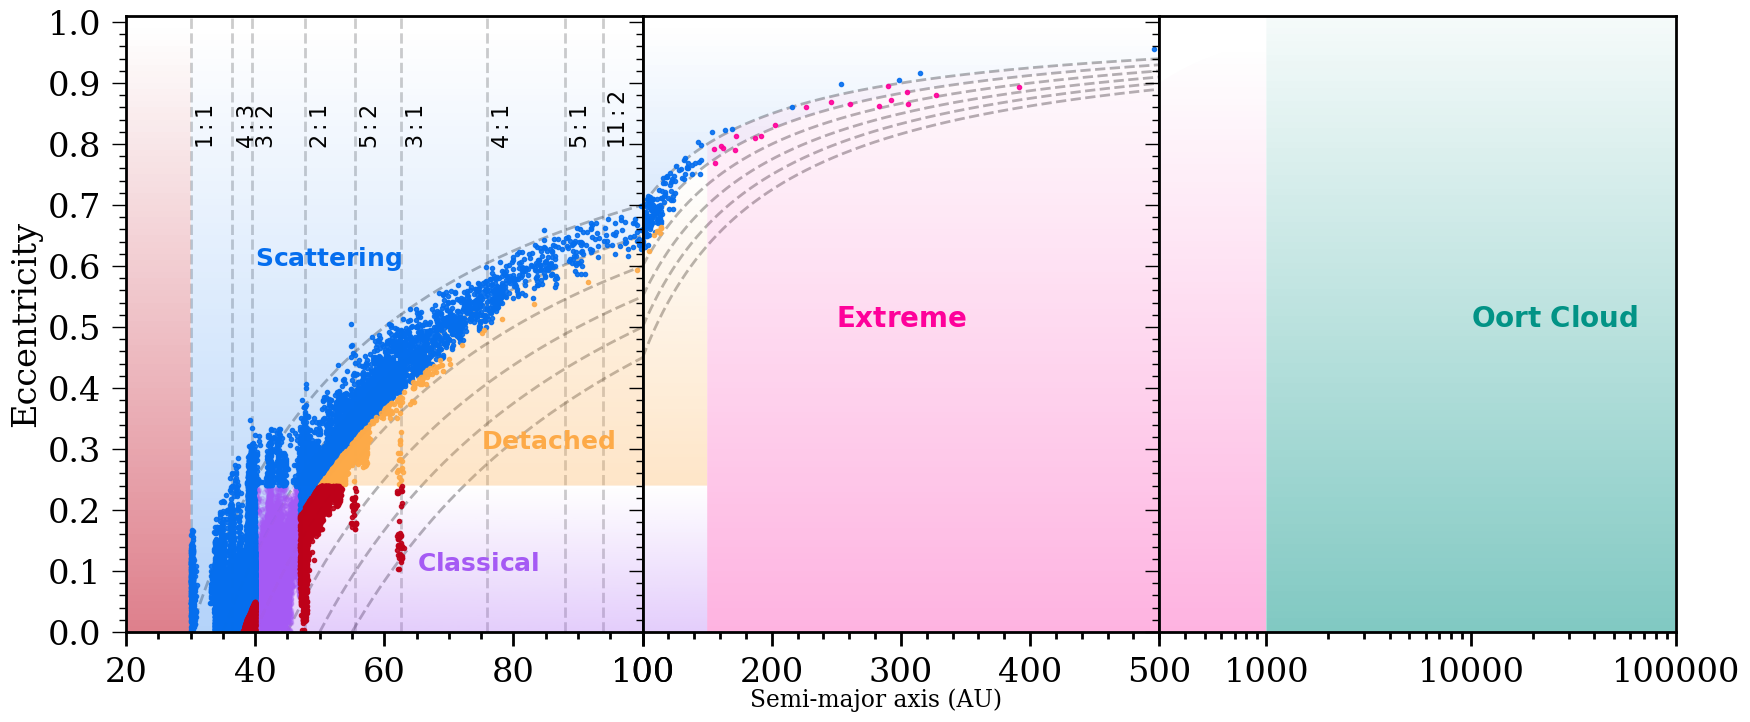

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

plt.rcParams["image.composite_image"] = False

e = np.linspace(0,0.9999999,10000)

for i in [30,35, 40, 45, 50,55]:
    ax1.plot(i/(1-e), e, 'k--', alpha=0.3)
    ax2.plot(i/(1-e), e, 'k--', alpha=0.3)
#pl.plot([47.7,1000],[0.24,0.24] )

for i,j in zip([1,2,3,3, 4,4, 5 ,5, 11  ], [1,1,1,2, 1, 3, 2, 1, 2 ]):
    ax1 = plotResonances(ax1, i, j, 0.8)

gradientFill(30/(1-e), e, ax=ax1, alpha=0.3, invert=True)

a_det = 35/(1-e)[e > 0.24]
e_det = e[e>0.24]
gradientFill(35/(1-e)[e > 0.24], e[e>0.24], ax=ax1, alpha=0.3, color='xkcd:light orange')
gradientFill(a_det[a_det<150], e_det[a_det<150], ax=ax2, alpha=0.3, color='xkcd:light orange')
scat = np.append(30/(1-e), 35/(1-e)[::-1])
scat_e = np.append(e, e[::-1])

gradientFill(scat, scat_e, ax=ax1, alpha=0.3, color='xkcd:cerulean blue')
gradientFill(scat, scat_e, ax=ax2, alpha=0.3, color='xkcd:cerulean blue')
gradientFill(30/(1-e), e, ax=ax2, alpha=0.5, invert=True, color='xkcd:cerulean blue')


cl = np.append(35/(1-e)[e < 0.24], 150)
msk = cl<151
e_cl = np.append(e[e<0.24],0.24)

gradientFill(cl, e_cl, ax=ax1, alpha=0.3, color='xkcd:lighter purple')

gradientFill(cl[msk], e_cl[msk], ax=ax2, alpha=0.3, color='xkcd:lighter purple')

cl = np.append(35/(1-e)[e < 0.24], 150)
e_cl = np.append(e[e<0.24],0.24)

gradientFill(np.array([20,30,30]), np.array([0,0,1]), ax=ax1, alpha=0.5, invert=True, color='xkcd:scarlet')

a = 30/(1-e)
gradientFill(np.append(150,a[a>150]), np.append(0,e[a>150]), ax=ax2, alpha=0.3, color='xkcd:neon pink')
gradientFill(np.append(150,a[a<1000]), np.append(0,e[a<1000]), ax=ax3, alpha=0.3, color='xkcd:neon pink')

for c, j in zip(['Classical', 'Scattering', 'Detached', 'Extreme', '     Other'],
                ['xkcd:lighter purple', 'xkcd:cerulean blue', 'xkcd:light orange', 
                 'xkcd:neon pink', 'xkcd:scarlet']):
    b = tnos[tnos['class'] == c]
    print (c, len(b))
    alp = 0.9
    if c == 'Classical':
        alp = 0.2
    ax1.plot(b['a'], b['e'], '.', alpha=alp, color=j)
    ax2.plot(b['a'], b['e'], '.', alpha=alp, color=j)

ax1.text(40, 0.6, r'$\bf{Scattering}$', rotation=0, color='xkcd:cerulean blue', fontsize=18,)
ax1.text(75, 0.3, r'$\bf{Detached}$', rotation=0, color='xkcd:light orange', fontsize=18,)
ax1.text(65, 0.1, r'$\bf{Classical}$', rotation=0, color='xkcd:lighter purple', fontsize=18,)
ax2.text(250, 0.5, r'$\bf{Extreme}$', rotation=0, color='xkcd:neon pink', fontsize=20,)
ax3.text(10000, 0.5, r'$\bf{Oort\ Cloud}$', rotation=0, color='xkcd:teal', fontsize=20,)
    
ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

ax1.set_ylim(0,1.01)
fig.supxlabel('Semi-major axis (AU)')
ax1.set_ylabel('Eccentricity')
ax1.set_xlim(20,100)
ax2.set_xlim(100,500)
ax3.set_xlim(300,100000)
ax3.set_xscale('log')
gradientFill(np.array([1000,300000,300000]), np.array([0,0,1.1]), ax = ax3, alpha=0.5, invert=True, color='xkcd:teal')

ax3.set_xticks([1000, 10000, 100000], labels=['1000', '10000', '100000'])
fig.set_size_inches(20,8)
plt.show()

## 5. Visualize orbits for each dynamical class

We can use the orbital elements from the TNOs to visualize their orbits (including comets). We can identify patterns in orbits of different dynamical classes, for example, the clustering of extreme objects that some researchers argue is evidence in favor of the existence of P9/PX. 

### 5.1 Define functions for plotting

In [68]:
def q_func(E, a, e):
    """
    Computes the coordinate vector q = (a * (cos(E) - e),
    a * sqrt(1 - e^2) * sin(E), 0),
    on the plane of the ellipse.
    """
    q1 = a * (np.cos(E) - e)
    q2 = a * np.sqrt(1. - e ** 2) * np.sin(E)

    if isinstance(q1, float):
        return np.array([q1, q2, 0.])
    else:
        return np.array([q1, q2, np.zeros_like(q1)])

In [69]:
def R(omega, Omega, i):
    """
    Computes the rotation matrix R = R(Omega, omega, i) that
    maps from the plane of the ellipse to 3D space aligned
    with the ecliptic plane.
    """
    cO = np.cos(np.pi * Omega / 180)
    sO = np.sin(np.pi * Omega / 180)
    co = np.cos(np.pi * omega / 180)
    so = np.sin(np.pi * omega / 180)
    ci = np.cos(np.pi * i / 180)
    si = np.sin(np.pi * i / 180)

    R = np.array([[cO * co - sO * so * ci, -cO * so - sO * co * ci, sO * si],
                  [sO * co + cO * so * ci, -sO * so + cO * co * ci, -cO * si],
                  [si * so, si * co, ci]])

    return R


In [70]:
def full_ellipse(a, e, i, Omega, omega):
    """
    Computes the coordinates of the full ellipse in 3D space.
    """
    E = np.linspace(0, 2 * np.pi, 2000)
    q_vec = q_func(E, a, e)
    Rot = R(omega, Omega, i)
    x = np.einsum('ij, j...', Rot, q_vec)

    return x

### 5.2 Calculate the full orbital ellipse per object

Calculte the ellipse per object, and append it to the catalog as an extra column

In [71]:
ellipse_vec = []
for i in tnos:
    ellipse_vec.append(full_ellipse(i['a'], i['e'], i['incl'], i['node'], i['peri']))
tnos['ellipse_vec'] = ellipse_vec

Let's plot the first 100 objects, so it doesn't take forever and it doesn't get too crowded.

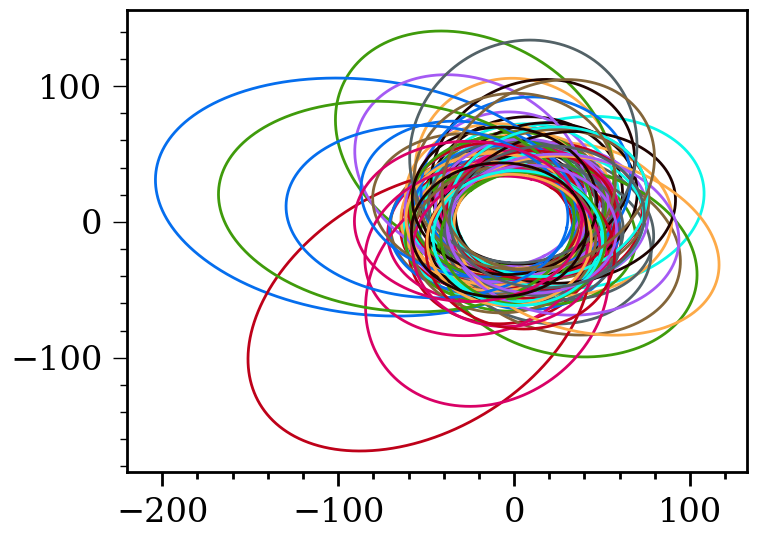

In [72]:
for i in tnos[:100]:
    plt.plot(i['ellipse_vec'][:,0], i['ellipse_vec'][:,1])

### 5.3 Illustrate the orbits of each dynamical class

Plot a 2x2 grid of 4 panels which shows 2-3 orbits of each dynamical class in each panel?

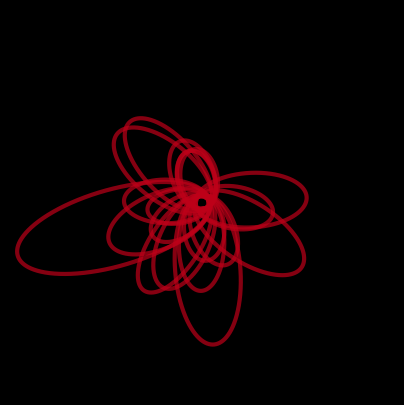

In [75]:
fig = plt.figure()
fig.set_size_inches(5, 5)
plt.rcParams['figure.facecolor'] = 'black'
plt.axes().set_aspect('equal')
colors = {'Resonant' : '#9ed4bf', 'Classical' : '#9ed4bf', 'Scattering': '#9ed4bf',
          'Detached' : '#9ed4bf', 'Oort cloud' : '#9ed4bf', 'Inner Centaur' : '#9ed4bf'}
alphas = {'Resonant' : 0.1, 'Classical' : 0.1, 'Scattering' : 0.1, 'Detached': 0.1, 'Inner Centaur' : 0.1, 'Oort cloud' : 0.1}
alphas_dist = {'Resonant' : 0.2, 'Classical' : 0.2, 'Scattering' : 0.2, 'Detached': 0.2, 'Inner Centaur' : 0.2, 'Oort cloud' :0.2}
tnos.sort('a')
for i in tnos[tnos['class'] == 'Extreme']:
    plt.plot(i['ellipse_vec'][:,0], i['ellipse_vec'][:,1], 'xkcd:scarlet',
             linewidth=3, alpha=0.7)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.axis('off')
plt.show()

In [ ]:
# From Pedro: " The above results is expected, and it also says a lot about expected results from LSST!
#The S3M model predates the whole Planet 9 stuff (and is old enough that these more exotic 
# populations are not representative of what we have learned from the more recent surveys)
#But this does an excellent job of showing that LSST will see the signal or not easily!"

## 6. Visualize a TNO in the deep drilling field

Since TNOs are distant they move slowly across the sky, with motions as low as 
a few degrees over 10 years, the duration of the LSST survey.

As the LSST Deep Drilling Fields (add link) are the size of the field of view of the  
LSST Science Camera, 9.6 square degrees, and recieve thousands of visits (observations)
over the 10 year survey, a single TNO can have a great many observations.

See Step 2 of:
https://github.com/lsst/dp0-3_lsst_io/blob/tickets/PREOPS-3498/tutorials-dp0-3/portal-dp0-3-3.rst

First do a query that gets you all the TNOs with the most number of observations.

Then single out the one with ssObjectId = -735085100561880491.

Then proceed with the following. If you can color the plot below by date like in the Portal tutorial that would be great.

In [79]:
my_object = service.search("SELECT ra, decl, mag, filter, midPointTai "
                           "FROM dp03_catalogs.DiaSource "
                           "WHERE ssObjectId = -735085100561880491").to_table()

In [81]:
plt.rcParams['figure.facecolor'] = 'white'

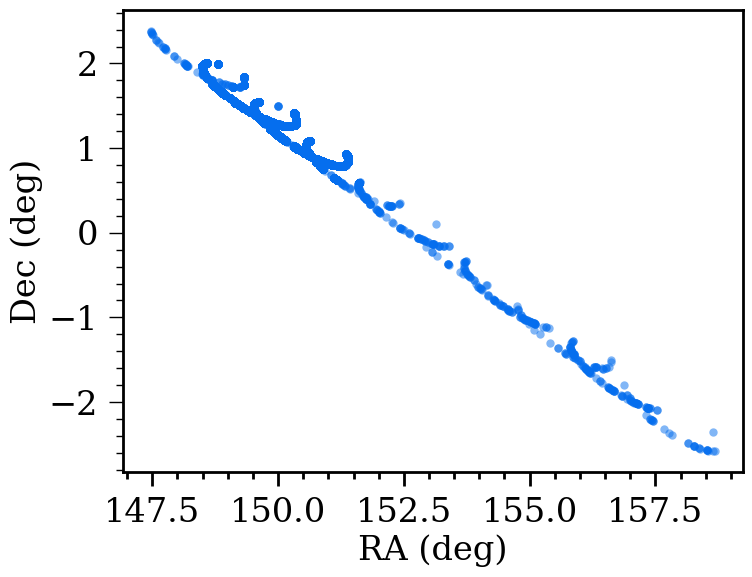

In [84]:
plt.plot(my_object['ra'], my_object['decl'], 'o', alpha=0.5, mew=0)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

## 7. Excersises for the learner

- Define cuts and plot the "Resonant" class in the e-i-a plots. 
